In [180]:
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

Things We should look at 
- how homogenous are today's festivals?
- what are the festivals that stand out as most unique? most median?
- what bands are the most "promiscuous" festival acts?
- are there other interesting patterns that indicate "behind the scenes" factors, such as shared booking/promoters, etc.?
- if you made a "consensus" festival for 2016, what would it look like? (would be great to design a fake poster for this)


In [530]:
df = pd.read_csv('/Users/hunterowens/Downloads/Festivals - 2016 (1).csv')

In [531]:
df.drop([0,1,2], inplace=True)
df.drop(['AVG RANK','# OF FESTS', 'PWR RANKING', 'Unnamed: 4',
        'ACL', 'EAUXCLAIRE','Unnamed: 26','BUMBERSHT']
        , axis=1, inplace=True)
df.set_index('ARTIST', inplace=True)

## Homogentity Score
- How similar to the avg festival is this festival 
- Computed Value is the Percentage of the Festival that appears in another fesitival 

In [532]:
def compute_percentage_of_lineup_in_other_festivals(lineup, df): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival """
    sum_lineup = df[lineup].count()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    fest_lineup_list = df[lineup].dropna().index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / sum_lineup
    return percentage

In [533]:
d = {}
for column in df.columns.get_values():
    d[column] = 1 - compute_percentage_of_lineup_in_other_festivals(column, df)

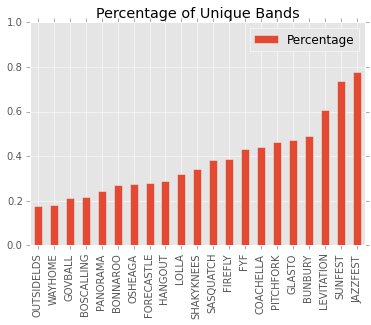

In [534]:
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
percentage_fest_df.columns = ['Percentage']
percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
                                                     title="Percentage of Unique Bands",
                                                     ylim=(0,1))

## Percentage of Unique Bands in Percentiles of Lineup 

In [535]:
def compute_percentage_of_lineup_in_other_festivals_percentile(lineup, df, percentile=1): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival. 
    Give a percentage of a lineup to cut by"""
    # get the sum
    sum_lineup = df[lineup].count()
    # get number in which to grab greater than
    sort_value = df[lineup].dropna().astype(int).sort_values().quantile(percentile)
    greater_than_true_series = df[lineup].dropna().astype(int) > sort_value
    fest_lineup_list = greater_than_true_series[greater_than_true_series == True].index.get_values()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / sum_lineup
    return percentage

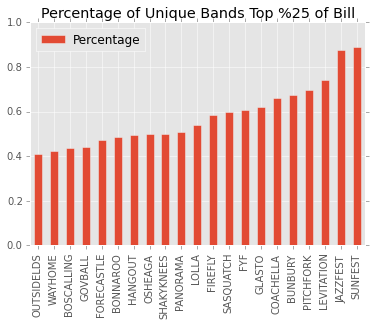

In [536]:
d = {}
for column in df.columns.get_values():
    d[column] = 1 - compute_percentage_of_lineup_in_other_festivals_percentile(column, df, .25)
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
percentage_fest_df.columns = ['Percentage']
percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
                                                     title="Percentage of Unique Bands Top %25 of Bill",
                                                     ylim=(0,1))

## What about bands
- What are the top 10 most promiscious bands? 

In [537]:
df.count(axis=1).sort_values(ascending=False).head(25)

ARTIST
Vince Staples                            13
Nathaniel Rateliff & the Night Sweats    10
M83                                       9
Foals                                     9
Grimes                                    9
Kurt Vile & The Violators                 8
Oh Wonder                                 8
LCD Soundsystem                           8
Haim                                      8
Disclosure                                7
Big Grams                                 7
Marian Hill                               7
Major Lazer                               7
CHVRCHES                                  6
Miike Snow                                6
Silversun Pickups                         6
Sufjan Stevens                            6
Lany                                      6
Børns                                     6
Savages                                   6
The Last Shadow Puppets                   6
Unknown Mortal Orchestra                  6
Elle King                

In [538]:
df.columns

Index(['COACHELLA', 'GOVBALL', 'BONNAROO', 'JAZZFEST', 'SUNFEST', 'LEVITATION',
       'SHAKYKNEES', 'HANGOUT', 'BOSCALLING', 'SASQUATCH', 'BUNBURY',
       'FIREFLY', 'GLASTO', 'FORECASTLE', 'PITCHFORK', 'PANORAMA', 'WAYHOME',
       'LOLLA', 'OSHEAGA', 'OUTSIDELDS', 'FYF'],
      dtype='object')

## Power Rankings
* We calculate a power rank based on three factors. 
* Percentile Rank within Festival 
* number of festival apperances 
* Size of festival apperance 

The Algorithm then becomes

*sum(1 - (rank in fest / size of fest))*

In [539]:
def calculate_power_rank(artist):
    """Calculates the power rankings"""
    artist_series = df.ix[artist]
    power_rank = 0
    for fest_tuple in artist_series.iteritems():        
        if not pd.isnull(fest_tuple[1]): 
            fest_count = df[fest_tuple[0]].count()
            artist_rank = fest_tuple[1]
            power_rank += 1.0 - (float(artist_rank) / float(fest_count))
    return power_rank

In [557]:
power_ranks = {}
for artist in df.index:
    power_ranks[artist] = calculate_power_rank(artist)
power_rank_df = pd.DataFrame.from_dict(power_ranks, orient='index')
power_rank_df = power_rank_df.rename(columns={0: "Artist"})

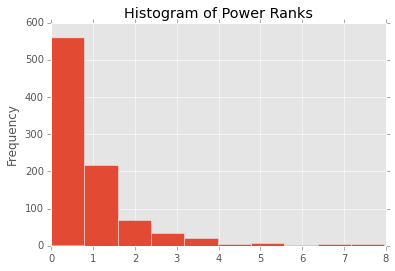

In [565]:
power_rank_df['Artist'].sort_values().plot(kind='hist', title="Histogram of Power Ranks")

In [569]:
# Top 10
power_rank_df['Artist'].sort_values().tail(10)

Kurt Vile & The Violators                5.722059
Major Lazer                              6.547164
Disclosure                               6.591571
Nathaniel Rateliff & the Night Sweats    7.049541
Haim                                     7.057156
Foals                                    7.306767
Vince Staples                            7.523252
Grimes                                   7.664336
LCD Soundsystem                          7.775041
M83                                      7.956220
Name: Artist, dtype: float64

## Festivals WAR over Bands 
* This is each festivals WAR divided by the number of bands in the fest  - basically avg rank

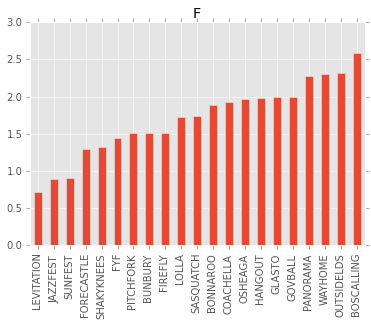

In [602]:
festival_rank = {} 
for festival in df.iteritems():
    fest = festival[0]
    sum_ranks = 0
    for artist in df[fest].dropna().iteritems():
        sum_ranks += power_rank_df.ix[artist[0]][0]
    festival_rank[fest] = sum_ranks / df[fest].count()
pd.DataFrame.from_dict(festival_rank, orient='index')[0].sort_values().plot(kind="bar", title="F")

In [603]:
power_rank_df.ix['2 Many DJs'][0]

0.91304347826086962